In [3]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
    validation_curve,
)

from skompiler import skompile
import graphviz
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.simplefilter(action="ignore", category=Warning)

In [4]:
diabetes = pd.read_csv("./datasets/diabetes.csv")
df = diabetes.copy()
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)
# confusian matrix için y_pred değerleri

y_pred = cart_model.predict(X)
# AUC için y_prob değerleri

y_prob = cart_model.predict_proba(X)[:, 1]
print(classification_report(y, y_pred))
# AUC Score

roc_auc_score(y, y_prob)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



1.0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=45
)

In [6]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

In [7]:
y_pred = cart_model.predict(X_train)

In [8]:
y_prob = cart_model.predict_proba(X_train)[:, 1]

In [9]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       191

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



In [10]:
roc_auc_score(y_train, y_prob)

1.0

In [11]:
y_pred = cart_model.predict(X_test)

In [12]:
y_prob = cart_model.predict_proba(X_test)[:, 1]

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       154
           1       0.53      0.56      0.54        77

    accuracy                           0.69       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.69      0.69      0.69       231



In [14]:
roc_auc_score(y_test, y_prob)

0.6558441558441559

In [15]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

In [16]:
cv_results = cross_validate(
    cart_model, X, y, cv=5, scoring=["roc_auc", "accuracy", "recall", "precision", "f1"]
)

In [17]:
cv_results["test_accuracy"].mean()
# 0.7058568882098294

cv_results["test_f1"].mean()
# 0.5710621194523633

cv_results["test_roc_auc"].mean()
# 0.6719440950384347

cv_results["test_recall"].mean()

0.5598881900768693

In [18]:
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [19]:
cart_params = {"max_depth": range(1, 11), "min_samples_split": range(2, 20)}

In [20]:
cart_best_params = GridSearchCV(
    cart_model, cart_params, cv=5, n_jobs=-1, verbose=1, scoring="accuracy"
).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [21]:
print(cart_best_params.best_params_)

{'max_depth': 5, 'min_samples_split': 4}


In [22]:
print(cart_best_params.best_score_)

0.7500806383159324


In [23]:
random = X.sample(1, random_state=45)

In [24]:
cart_best_params.predict(random)

array([1], dtype=int64)

In [26]:
cart_final = DecisionTreeClassifier(
    **cart_best_params.best_params_, random_state=17
).fit(X, y)

In [27]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [28]:
cart_final = cart_model.set_params(**cart_best_params.best_params_).fit(X, y)

In [29]:
cv_results = cross_validate(
    cart_final, X, y, cv=5, scoring=["roc_auc", "accuracy", "recall", "precision", "f1"]
)

In [30]:
cv_results["test_accuracy"].mean()

0.7500806383159324

In [31]:
cv_results["test_f1"].mean()

0.614625004082526

In [32]:
cv_results["test_roc_auc"].mean()

0.797796645702306

In [33]:
cv_results["test_recall"].mean()

0.571278825995807

In [34]:
cart_final.feature_importances_

array([0.01129738, 0.49448119, 0.05065617, 0.        , 0.01497644,
       0.22221379, 0.06819923, 0.13817579])

In [35]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame(
        {"Value": model.feature_importances_, "Feature": features.columns}
    )
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
    )
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

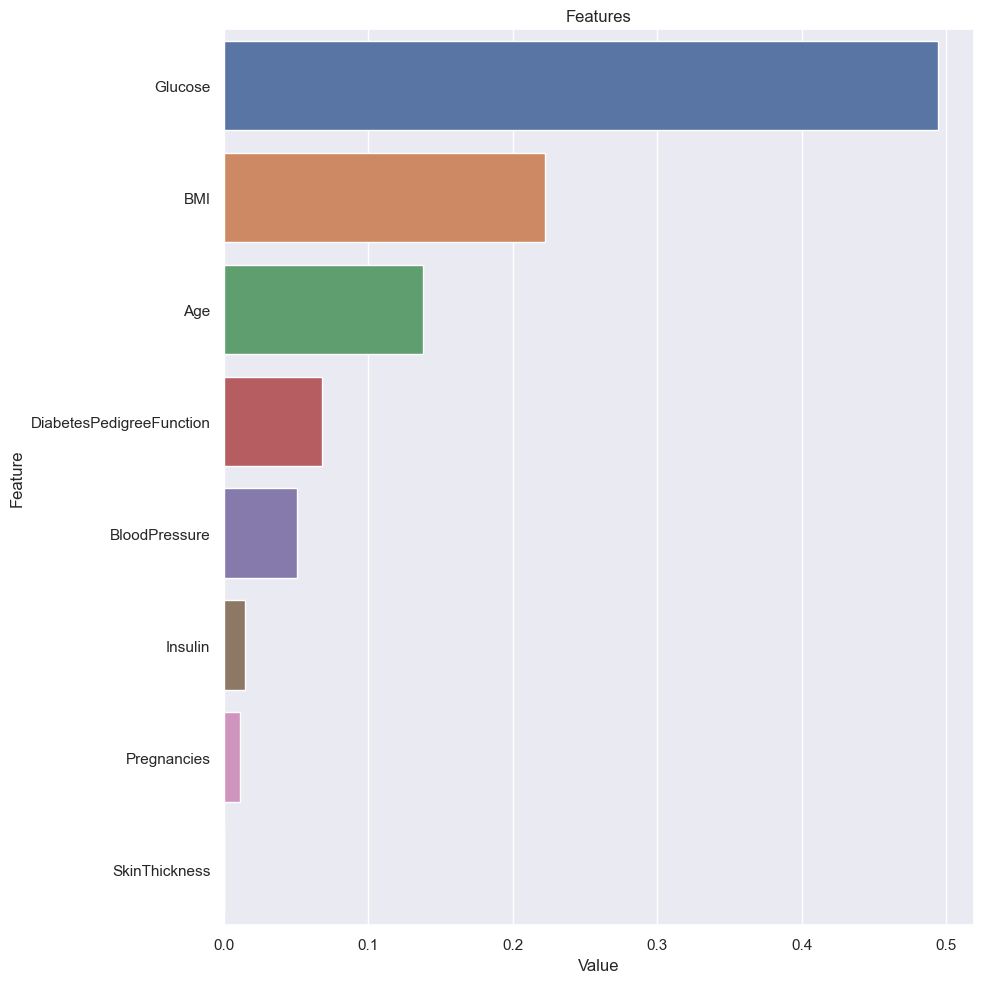

<Figure size 640x480 with 0 Axes>

In [36]:
plot_importance(cart_final, X, 10, save=True)

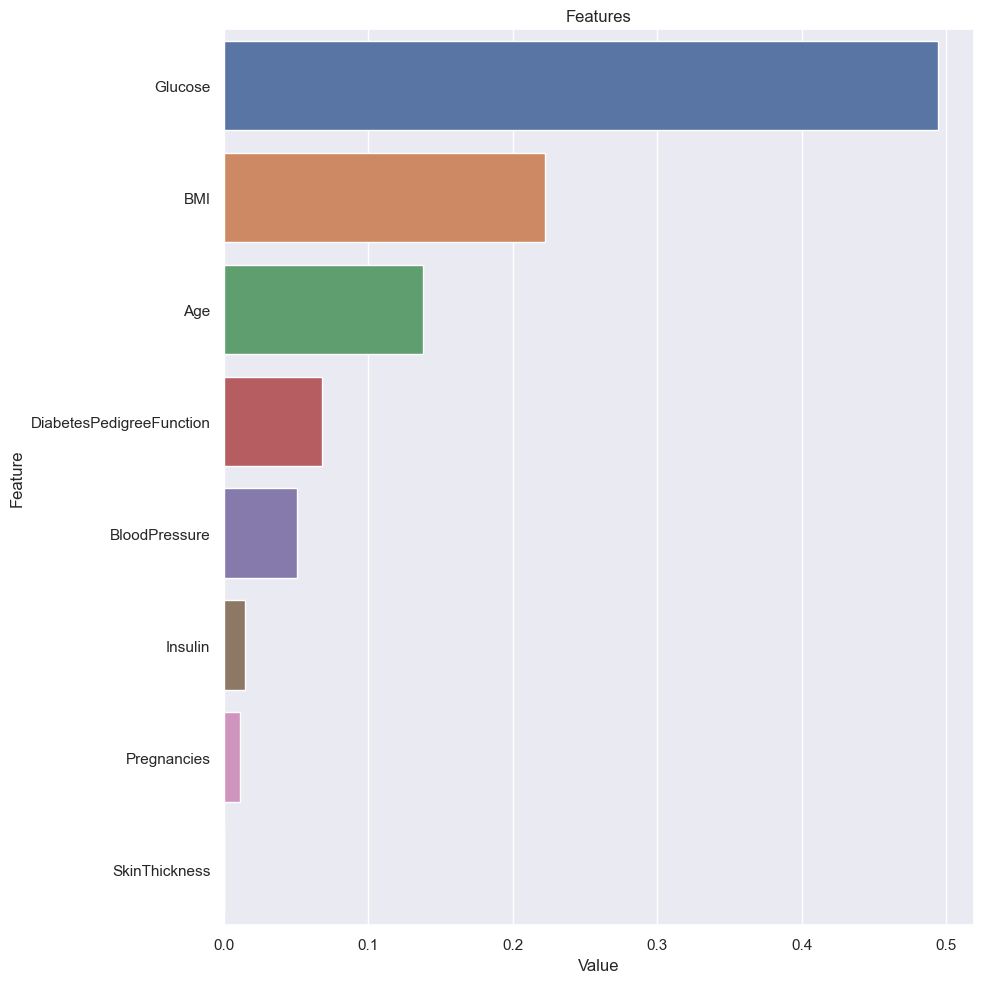

In [37]:
plot_importance(cart_final, X, 10, save=0)

In [38]:
train_score, test_score = validation_curve(
    cart_final,
    X,
    y,
    param_name="max_depth",
    param_range=range(1, 11),
    scoring="roc_auc",
    cv=10,
)

In [39]:
mean_train_score = np.mean(train_score, axis=1)

In [40]:
mean_test_score = np.mean(test_score, axis=1)

In [41]:
mean_train_score

array([0.70729413, 0.78976751, 0.83642714, 0.87603684, 0.90819184,
       0.93528351, 0.96013549, 0.97716774, 0.98781586, 0.99359846])

In [42]:
mean_test_score = np.mean(test_score, axis=1)

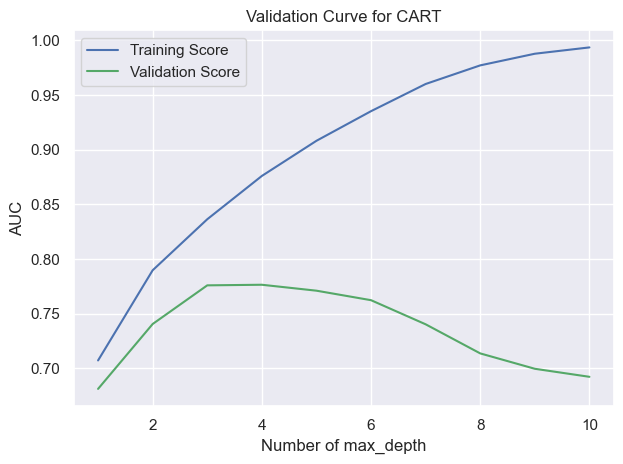

In [43]:
plt.plot(range(1, 11), mean_train_score, label="Training Score", color="b")
plt.plot(range(1, 11), mean_test_score, label="Validation Score", color="g")
plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
    )
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.plot(param_range, mean_train_score, label="Training Score", color="b")
    plt.plot(param_range, mean_test_score, label="Validation Score", color="g")
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)

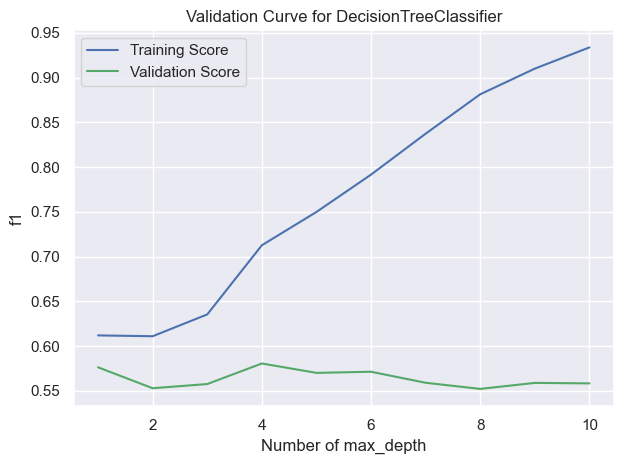

In [44]:
val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="f1")

In [45]:
cart_val_params = [["max_depth", range(1, 11)], ["min_samples_split", range(2, 20)]]

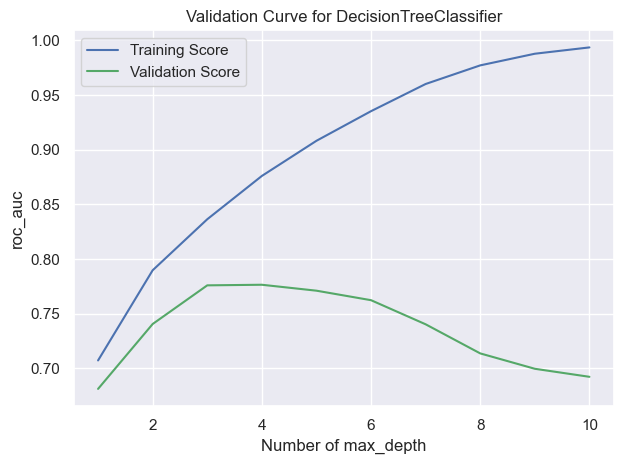

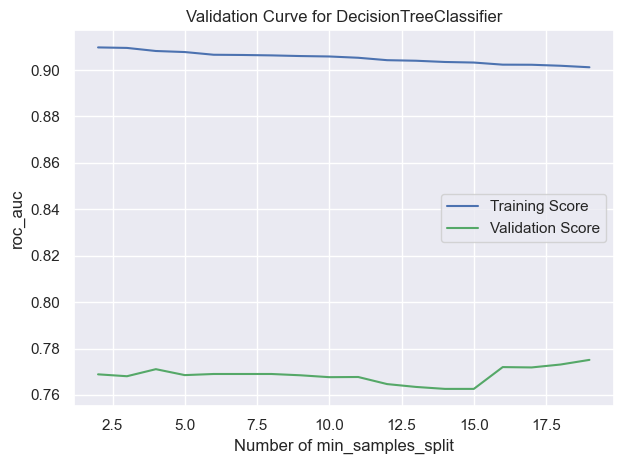

In [46]:
for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [47]:
def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(
        model, feature_names=col_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)

In [48]:
tree_graph(model=cart_final, col_names=X.columns, file_name="cart_final.png")

In [49]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [50]:
tree_rules = export_text(cart_final, feature_names=list(X.columns))

In [51]:
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- BloodPressure <= 99.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  99.00
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- Glucose <= 28.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Glucose >  28.50
|   |   |   |   |   |--- class: 0
|   |  

In [52]:
print(skompile(cart_final.predict).to("python/code"))

(((((0 if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else 0 if x[6] <=
    0.5005000084638596 else 0) if x[5] <= 45.39999961853027 else 1 if x[2] <=
    99.0 else 0) if x[7] <= 28.5 else (1 if x[5] <= 9.649999618530273 else 
    0) if x[5] <= 26.350000381469727 else (1 if x[1] <= 28.5 else 0) if x[1
    ] <= 99.5 else 0 if x[6] <= 0.5609999895095825 else 1) if x[1] <= 127.5
     else (((0 if x[5] <= 28.149999618530273 else 1) if x[4] <= 132.5 else 
    0) if x[1] <= 145.5 else 0 if x[7] <= 25.5 else 1 if x[7] <= 61.0 else 
    0) if x[5] <= 29.949999809265137 else ((1 if x[2] <= 61.0 else 0) if x[
    7] <= 30.5 else 1 if x[6] <= 0.4294999986886978 else 1) if x[1] <= 
    157.5 else (1 if x[6] <= 0.3004999905824661 else 1) if x[4] <= 629.5 else 0
    )



In [3]:
print(skompile(cart_final.predict).to("excel"))

A1=IF((x2<=127.5),IF((x ...418 chars skipped... ((x5<=629.5),1,0))))


In [4]:
def predict_with_rules(x):
    return ((((((0 if x[6] <= 0.671999990940094 else 1 if x[6] <= 0.6864999830722809 else
        0) if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else ((1 if x[5
        ] <= 32.45000076293945 else 1 if x[3] <= 10.5 else 0) if x[2] <= 53.0 else
        ((0 if x[1] <= 111.5 else 0 if x[2] <= 72.0 else 1 if x[3] <= 31.0 else
        0) if x[2] <= 82.5 else 1) if x[4] <= 36.5 else 0) if x[6] <=
        0.5005000084638596 else (0 if x[1] <= 88.5 else (((0 if x[0] <= 1.0 else
        1) if x[1] <= 98.5 else 1) if x[6] <= 0.9269999861717224 else 0) if x[1
        ] <= 116.0 else 0 if x[4] <= 166.0 else 1) if x[2] <= 69.0 else ((0 if
        x[2] <= 79.0 else 0 if x[1] <= 104.5 else 1) if x[3] <= 5.5 else 0) if
        x[6] <= 1.098000019788742 else 1) if x[5] <= 45.39999961853027 else 0 if
        x[7] <= 22.5 else 1) if x[7] <= 28.5 else (1 if x[5] <=
        9.649999618530273 else 0) if x[5] <= 26.350000381469727 else (1 if x[1] <=
        28.5 else ((0 if x[0] <= 11.5 else 1 if x[5] <= 31.25 else 0) if x[1] <=
        94.5 else (1 if x[5] <= 36.19999885559082 else 0) if x[1] <= 97.5 else
        0) if x[6] <= 0.7960000038146973 else 0 if x[0] <= 3.0 else (1 if x[6] <=
        0.9614999890327454 else 0) if x[3] <= 20.0 else 1) if x[1] <= 99.5 else
        ((1 if x[5] <= 27.649999618530273 else 0 if x[0] <= 5.5 else (((1 if x[
        0] <= 7.0 else 0) if x[1] <= 103.5 else 0) if x[1] <= 118.5 else 1) if
        x[0] <= 9.0 else 0) if x[6] <= 0.19999999552965164 else ((0 if x[5] <=
        36.14999961853027 else 1) if x[1] <= 113.0 else 1) if x[0] <= 1.5 else
        (1 if x[6] <= 0.3620000034570694 else 1 if x[5] <= 30.050000190734863 else
        0) if x[2] <= 67.0 else (((0 if x[6] <= 0.2524999976158142 else 1) if x
        [1] <= 120.0 else 1 if x[6] <= 0.23899999260902405 else 1 if x[7] <=
        30.5 else 0) if x[2] <= 83.0 else 0) if x[5] <= 34.45000076293945 else
        1 if x[1] <= 101.0 else 0 if x[5] <= 43.10000038146973 else 1) if x[6] <=
        0.5609999895095825 else ((0 if x[7] <= 34.5 else 1 if x[5] <=
        33.14999961853027 else 0) if x[4] <= 120.5 else (1 if x[3] <= 47.5 else
        0) if x[4] <= 225.0 else 0) if x[0] <= 6.5 else 1) if x[1] <= 127.5 else
        (((((1 if x[1] <= 129.5 else ((1 if x[6] <= 0.5444999933242798 else 0) if
        x[2] <= 56.0 else 0) if x[2] <= 71.0 else 1) if x[2] <= 73.0 else 0) if
        x[5] <= 28.149999618530273 else (1 if x[1] <= 135.0 else 0) if x[3] <=
        21.0 else 1) if x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <=
        25.5 else ((0 if x[1] <= 151.0 else 1) if x[5] <= 27.09999942779541 else
        ((1 if x[0] <= 6.5 else 0) if x[6] <= 0.3974999934434891 else 0) if x[2
        ] <= 82.0 else 0) if x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137
         else ((1 if x[2] <= 61.0 else (((((0 if x[6] <= 0.18299999833106995 else
        1) if x[0] <= 0.5 else 1 if x[5] <= 32.45000076293945 else 0) if x[2] <=
        73.0 else 0) if x[0] <= 4.5 else 1 if x[6] <= 0.6169999837875366 else 0
        ) if x[6] <= 1.1414999961853027 else 1) if x[5] <= 41.79999923706055 else
        1 if x[6] <= 0.37299999594688416 else 1 if x[1] <= 142.5 else 0) if x[7
        ] <= 30.5 else (((1 if x[6] <= 0.13649999350309372 else 0 if x[5] <=
        32.45000076293945 else 1 if x[5] <= 33.05000114440918 else (0 if x[6] <=
        0.25599999725818634 else (0 if x[1] <= 130.5 else 1) if x[0] <= 8.5 else
        0) if x[0] <= 13.5 else 1) if x[2] <= 92.0 else 1) if x[5] <=
        45.54999923706055 else 1) if x[6] <= 0.4294999986886978 else (1 if x[5] <=
        40.05000114440918 else 0 if x[5] <= 40.89999961853027 else 1) if x[4] <=
        333.5 else 1 if x[2] <= 64.0 else 0) if x[1] <= 157.5 else ((((1 if x[7
        ] <= 25.5 else 0 if x[4] <= 87.5 else 1 if x[5] <= 45.60000038146973 else
        0) if x[7] <= 37.5 else 1 if x[7] <= 56.5 else 0 if x[6] <=
        0.22100000083446503 else 1) if x[6] <= 0.28849999606609344 else 0) if x
        [6] <= 0.3004999905824661 else 1 if x[7] <= 44.0 else (0 if x[7] <=
        51.0 else 1 if x[6] <= 1.1565000414848328 else 0) if x[0] <= 6.5 else 1
        ) if x[4] <= 629.5 else 1 if x[6] <= 0.4124999940395355 else 0)

In [5]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [6]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

In [7]:
predict_with_rules(x)

0

In [8]:
x = [6, 148, 70, 35, 0, 30, 0.62, 50]

In [9]:
predict_with_rules(x)

1

In [10]:
joblib.dump(cart_final, "cart_final.pkl")

['cart_final.pkl']

In [11]:
cart_model_from_disc = joblib.load("cart_final.pkl")

In [12]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

In [13]:
cart_model_from_disc.predict(pd.DataFrame(x).T)

array([1], dtype=int64)